In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.transforms as transforms
import numpy as np
import math as m
from venn import venn
import pygal
import plotly.express as pxf
import plotly
import ipywidgets as widgets
import seaborn as sns
from scipy import stats
from itertools import chain, islice
from IPython.display import SVG, display,HTML
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv

import water_treatment_functions as wtf


%load_ext autoreload
%autoreload 2

To Do
======
- Colocar legenda do tamanho no gráfico 3d
- Colocar elipsoide no gráfico 3d
- Adicionar texto no treemap com as porcentagens relativas
Maybe Do
- Testar mais casos com o pairplot das performances

Registro de Análises
=======================
(Baseado nas linhas quando o notebook é reiniciado)

[1] Importar os dados.

[2-] Estatísticas Gerais.
- [3] Descrição das variáveis (máx, min, média...)
- [4] Váriaveis com valores vazios
- [5] Linha com valores vazios
- [6] Box Plot das Variáveis
- [7] Estátisticas das Classificações
- [8] Estátistica dos Níveis

[9-10] Análise comparativa dos Níveis

[11] Normalização Media das Variáveis

[12] Coordenadas paralelas das correlações

[13] HeatMap com as Correlações entre as variáveis

[14] Scatter Plot Interativo entre as variáveis e com classificação

[15-16] Redução de dimensão por alta correlação

[17] Análise comparativa das Classificações Simples

[18] Pairplot das performances Originais

[19-27] Análise do Segundo Decantador
- [19-20] Cálculo das variáveis Performance e Variáveis absolutas 
- [21-24] Coordenadas Paralelas da Performance Normal vs Anormal
- [25] Pairplot das performances calculadas vs variáveis
- [26-27] Scatter Plot Interativo das variáveis novas  

[28] t-SNE

[29-38] PCA
- [29] Limpeza e cálculos
- [30-31] Variância Explicada
- [32-33] HeatMap dos Coeficientes dos Principais Componentes
- [34-35] Scatter do PCA
- [36-37] Pairplot e HeatMap dos Principais Componetes selecionados 

[38-] Análise do PCA
- [38-42] Análise das principais variáveis dos PC selecionados
    - [38] Determinação das Principais Variáveis
    - [39] Descrição 
    - [40-41] Gráfico 3d
    - [42] Coordenadas Paralelas

Backend
=======
1) Lista com os grupos de variáveis

2) Dicionário

3) Classificação dos dados

    3.1) Original
    
    3.2) Operação com base nos níveis aceitos na Literatura
    
    3.3) Performance com base na distribuição de kernel gaussiana
    
4) Funções gráficas: permitir os gráficos interativos

5) Tabela com as causas da operação anormal - nível variável 
    

Ideias de Análise
================
Análises

- Usar as próprias PCA para as análises
- Usar o TSNE para outra análise
- Segmentar a análise em processos:para tal, seria necessário determinar performances de cada operação. 
    - Para o segundo decantador, basta utilizar as condições máximas para que a operação seja normal, isso pode resultar em performance acima de 100% e pode ser imposto um limitador para que não ultrapasse esse valor. Um possível cálculo seria perf = lim/(v-lim), se v>lim e perf = 100%
    - Para a performance global, a mesma ideia do segundo decantador
    - Para o primeiro decantador, seria necessário fazer um estudo para ver como medir a performance. 
        - Uma ideia seria ver a quantidade absoluta de matéria que o primeiro decantador é capaz de processar. Isso pode ser comprovado traçando um scatter com a quantidade de matéria retida na operação m = '(P-D).Q' e ordená-lo do menor para o maior. Se a curva apresentar um valor máximo ou uma assindotá_horizontal a qual os pontos se aproximem dela. Por fim, calcula-se a perdormance = m/P.Q, com P.Q limitado pelo valor máximo 
    - Os outros casos de performance podem ser trabalhados da mesma forma
    - Caso seja possível calcular a performance para o primeiro decantador:
        - Calcular a vazão ótima de operação com base nas performances: identificar qual vazão apresenta a melhor performance
- Calcular a vazão ótima de operação: intervalo de vazão cuja probabilidade de ter falha é a menor possível e com um nível de representatividade dos dados e do intervalo de vazão (min e máx)
- Estatística sobre a causa mais frequente e ver como uma está relacionada com a outra
- Classificação voltada para o momento em que ocorreu a falha, ou seja, em qual corrente os valores ficaram acima do valor permitido
    - Como existem dias com mais de uma falha, será necessário construir outra tabela 
    - O critério pode ser a primeira operação a apresentar a performance baixa ou o valor absoluto abaixo do esperado
- PCA com a performance
- Análise usando os principais componentes d1° PC
Gráfico
- Ideia de gráfico: dimensões contínuas(gráfico 3d, escala de tonalidade, tamanho) dimensões de classificação(tipo de marcador e cor). A escolha do Cmap não pode ter o valor mínimo branco. Para isso fazer as variáveis irem de 0.5 até 1   
- Aplicar diferentes filtros ao gráfico de cordenada paralela
- Chord Diagram/Network grapf
- Rede Bayseana por gráfico -> gráfico de Dendrogram
- 3d ternary plot
- Venn diagram -> mt difícil
- Coordenadas Paralelas em 3d - um eixo é o classificador e os outros dois são os valores --> permite plotar duas variáveis no mesmo eixo, assim é possível comparar 4 variáveis simultaneamente em comparação à duas do gráfico padrão, no entanto o grande número de pontos pode tornar a interpretação difícil, sendo necessário aplicar um filtro mais restritivo e mostrar um número menor de dados

In [75]:
data = wtf.import_wt_data()
df_backup = data.copy()

ESTATÍSTICAS GERAIS

In [3]:
#Estátistica das variáveis
statistics = pd.DataFrame(index = data.columns,
                     data = {'mean': data.mean(),
                     'median': data.median(),
                     'min': data.min(),
                     'max': data.max(),
                     'std': data.std(),
                     '%std': 100*data.std()/data.mean()
                                 })
statistics = statistics[1:-4][:]
stat = data.describe().T
#Verificar se há alguma variável com pouca variância, dessa forma podemos desconsiderá-la
stat['std'] = stat['std']/stat['mean']
stat
#Todas as performances podem ser eventualmente desconsideradas, já o PH não tenho certeza 
# se ele pode ser considerado com pouca variância por ser -log
# Em geral, a performance global de sed não é um bom indicador para observar a performance

,count,mean,std,min,25%,50%,75%,max
Q-E,509.0,37226.567780,0.178260,10050.0,32888.00,35990.0,41372.0,60081.0
ZN-E,524.0,2.359065,1.165508,0.1,0.90,1.5,3.0,33.5
PH-E,527.0,7.810057,0.031520,6.9,7.60,7.8,8.0,8.7
DBO-E,504.0,188.714286,0.328872,31.0,146.75,182.5,223.0,438.0
DQO-E,521.0,406.898273,0.295806,81.0,325.00,400.0,478.0,941.0
...,...,...,...,...,...,...,...,...
level_SED-S,499.0,0.939880,0.253169,0.0,1.00,1.0,1.0,1.0
level_COND-S,526.0,0.589354,0.835525,0.0,0.00,1.0,1.0,1.0
level_SST-S,522.0,0.601533,0.814673,0.0,0.00,1.0,1.0,1.0
level_DBO-S,504.0,0.668651,0.704652,0.0,0.00,1.0,1.0,1.0


In [4]:
#Verificar se há alguma variável com muitos nan
pd.DataFrame(round(100*data.isna().sum()/len(data),2)).sort_values(0,ascending=False)
#Os valores de eficiência 

,0
RD-DBO-P,11.76
level_P_DBO-P,8.92
P_DBO-P,8.92
level_P_DBO-E,8.16
P_DBO-E,8.16
...,...
invalid_columns,0.00
class,0.00
level_G,0.00
P_COND-E,0.00


In [5]:
#Verificar se há algum dia com muitas variável nan
print(data[data['invalid_columns'].str.len()>=10].index)
nulos = pd.DataFrame(data['invalid_columns'].str.len().value_counts()).sort_index() 
nulos[nulos.index>=10].sum()
#Há poucos casos, pode ser desconsiderados

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-11', '1990-01-31',
               '1990-02-03', '1990-02-13', '1990-02-26', '1990-02-27',
               '1990-02-28', '1990-04-03', '1990-04-13', '1990-05-16',
               '1990-06-17', '1990-07-12', '1990-08-17', '1990-08-25',
               '1990-10-28', '1990-10-29', '1990-10-30', '1990-11-12',
               '1990-11-16', '1990-12-14', '1990-12-24', '1990-12-28',
               '1990-12-30', '1991-01-25', '1991-02-22', '1991-02-28',
               '1991-03-22', '1991-03-29', '1991-03-31', '1991-04-26',
               '1991-05-07', '1991-05-10', '1991-05-24', '1991-06-14',
               '1991-07-06', '1991-08-02', '1991-08-03', '1991-08-25',
               '1991-08-30', '1991-10-05', '1991-10-30', '1991-11-01',
               '1991-12-04'],
              dtype='datetime64[ns]', name=0, freq=None)


invalid_columns    45
dtype: int64

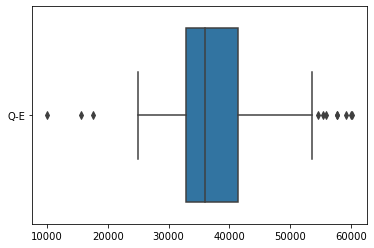

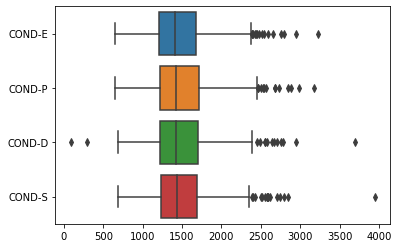

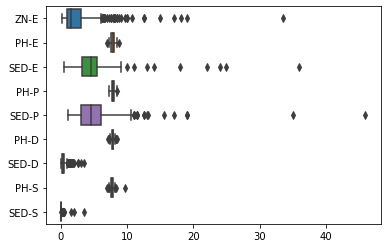

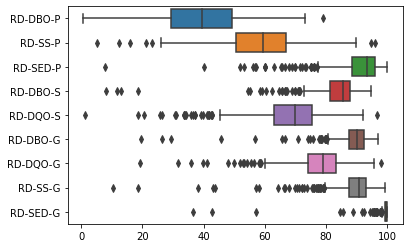

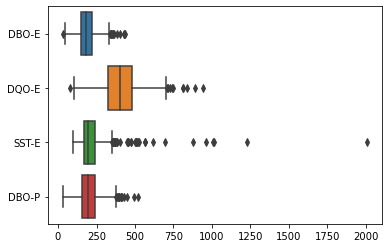

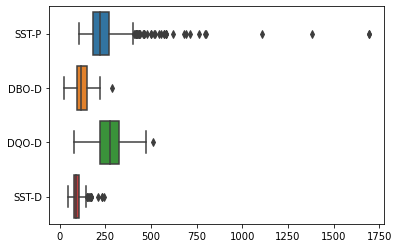

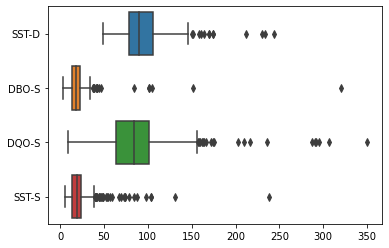

In [6]:
#Box Plot das variáveis
n = 3
sns.boxplot(data=data[['Q-E']],orient='h')
plt.show()
sns.boxplot(data=data[['COND-E','COND-P','COND-D','COND-S']], orient='h')
plt.show()
sns.boxplot(data=data[['ZN-E', 'PH-E', 'SED-E', 'PH-P', 'SED-P', 'PH-D', 'SED-D', 'PH-S',
                       'SED-S']], orient='h')
plt.show()
sns.boxplot(data=data[wtf.cols_group('performance_old')], orient='h')
plt.show()
lista = wtf.cols_group('value')
for i in ['Q-E','COND-P','COND-D','COND-S','COND-E','ZN-E', 'PH-E', 'SED-E', 'PH-P', 'SED-P', 'PH-D', 'SED-D',
          'PH-S', 'SED-S']+wtf.cols_group('performance_old'):
    lista.remove(i)
for i in range(n):
    tab = data[lista]
    l = tab.shape[1]
    r = l/n
    a = round(i*r)
    b = round(a+r)
    if b > l:
        b = l
    sns.boxplot(data=tab.iloc[:,a:b],orient='h')
    plt.show()
 

In [7]:
#Estatística da distribuição de variáveis
c = data.groupby('class_simp').count()
c['porcentage'] = round(100*c['month']/c['month'].sum(),2)
print(c[['month','porcentage']])
c = data.groupby('class').count()
c['porcentage'] = round(100*c['month']/c['month'].sum(),2)
print(c[['month','porcentage']])

                            month  porcentage
class_simp                                   
Normal                        514       97.53
Secondary settler problems      7        1.33
Solids overload                 4        0.76
Storm                           2        0.38
                                                 month  porcentage
class                                                             
Normal                                             300       56.93
Normal situation with low influent                  56       10.63
Normal situation with performance over the mean    108       20.49
Normal2                                             50        9.49
Secondary settler problems-1                         1        0.19
Secondary settler problems-2                         1        0.19
Secondary settler problems-3                         4        0.76
Secondary settler problems-4                         1        0.19
Solids overload-1                                    3

In [8]:
#Estatística das classificações de nível
level = wtf.cols_group('levelS')
stats_level_df = data[level[0]].value_counts(dropna=False).to_frame()
for c in wtf.cols_group('levelS')[1:]:
    stats_level_df[c] =  data[c].value_counts(dropna=False)
stats_level_df['level_G'] = data['level_G'].value_counts(dropna=False)
stats_level_df = stats_level_df.T
print(stats_level_df)
for c in stats_level_df.index:
    stats_level_df.loc[c] = round(100*stats_level_df.loc[c]/stats_level_df.sum(axis=1)[c],2)
stats_level_df

                1.0   NaN    0.0
level_PH-S    525.0   1.0    1.0
level_ZN-S    524.0   3.0    NaN
level_SED-S   469.0  28.0   30.0
level_COND-S  310.0   1.0  216.0
level_SST-S   314.0   5.0  208.0
level_DBO-S   337.0  23.0  167.0
level_DQO-S   380.0  18.0  129.0
level_G       163.0   NaN  364.0


,1.0,NaN,0.0
level_PH-S,99.62,0.19,0.19
level_ZN-S,99.43,0.57,NaN
level_SED-S,88.99,5.31,5.69
level_COND-S,58.82,0.19,40.99
level_SST-S,59.58,0.95,39.47
level_DBO-S,63.95,4.36,31.69
level_DQO-S,72.11,3.42,24.48
level_G,30.93,NaN,69.07


In [9]:
levelS = wtf.cols_group('levelS')
df = pd.DataFrame(columns=levelS)
for l in levelS:
    rel = data.copy()
    rel = rel[levelS]
    #rel = rel.dropna()
    rel = rel[rel[l]==False]
    rel = round(100*(rel.count()-rel.sum())/rel.count(),2)
    rel = rel.rename(l)
    df = df.append(rel)
#level_PH-S e level_ZN-S são sempre verdadeiros
print('Porcentagem de outras falhas simuntâneas à falha das linhas')
df = df.iloc[2:,2:]
df

Porcentagem de outras falhas simuntâneas à falha das linhas


,level_SED-S,level_COND-S,level_SST-S,level_DBO-S,level_DQO-S
level_SED-S,100.00,43.33,80.00,79.31,51.72
level_COND-S,6.34,100.00,49.54,35.44,29.52
level_SST-S,11.94,51.44,100.00,63.78,43.07
level_DBO-S,14.56,43.71,75.30,100.00,42.68
level_DQO-S,12.40,48.06,67.97,56.91,100.00


- As falhas de PH e ZN são inexistentes
- 80% dos casos de falha na sedimentação apresenta falhas na quantidade de sólidos susupensos e no nível de DBO, indicando uma relação de causa e efeito. No entanto, SST e DBO apresentam outras causas pois ao analisar as falhas destes apenas 12% e 15%, respectivamente, possuem elevados níveis de SED  
     - Quanto maior a quantidade de sedimentos, maior será a quantidade de sólidos suspensos
     - Já o aumento do DBO provavelmente está atrelado ao percentual de Sólidos Suspensos Orgânicos (SSV) que pode ser maior nos casos de SED acima do nível normal. 
         - Ao testar essa hipótese, percebe-se que os valores médios dos dias normais e acima do especificado são parecidos. E ao traçar a curva de distribuição para cada caso e observou-se o mesmo comportamento. O oposto da ideia inicial, os casos de acima do nível de SED tendem a ter um valor menor de SSV  

level_SED-S
0.0    79.5
1.0    81.3
Name: SSV-S, dtype: float64


array([<AxesSubplot:title={'center':'0.0'}>,
       <AxesSubplot:title={'center':'1.0'}>], dtype=object)

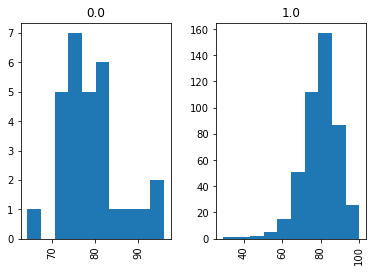

In [10]:
print(data.groupby('level_SED-S')['SSV-S'].median())
data.hist(column='SSV-S',by='level_SED-S',bins=10)

In [11]:
#Mean Normalization
data_mean_normalize = data.copy()
for c in wtf.cols_group('variable'):
    data_mean_normalize[c] = (data_mean_normalize[c]-data_mean_normalize[c].mean())/data_mean_normalize[c].std()

<AxesSubplot:>

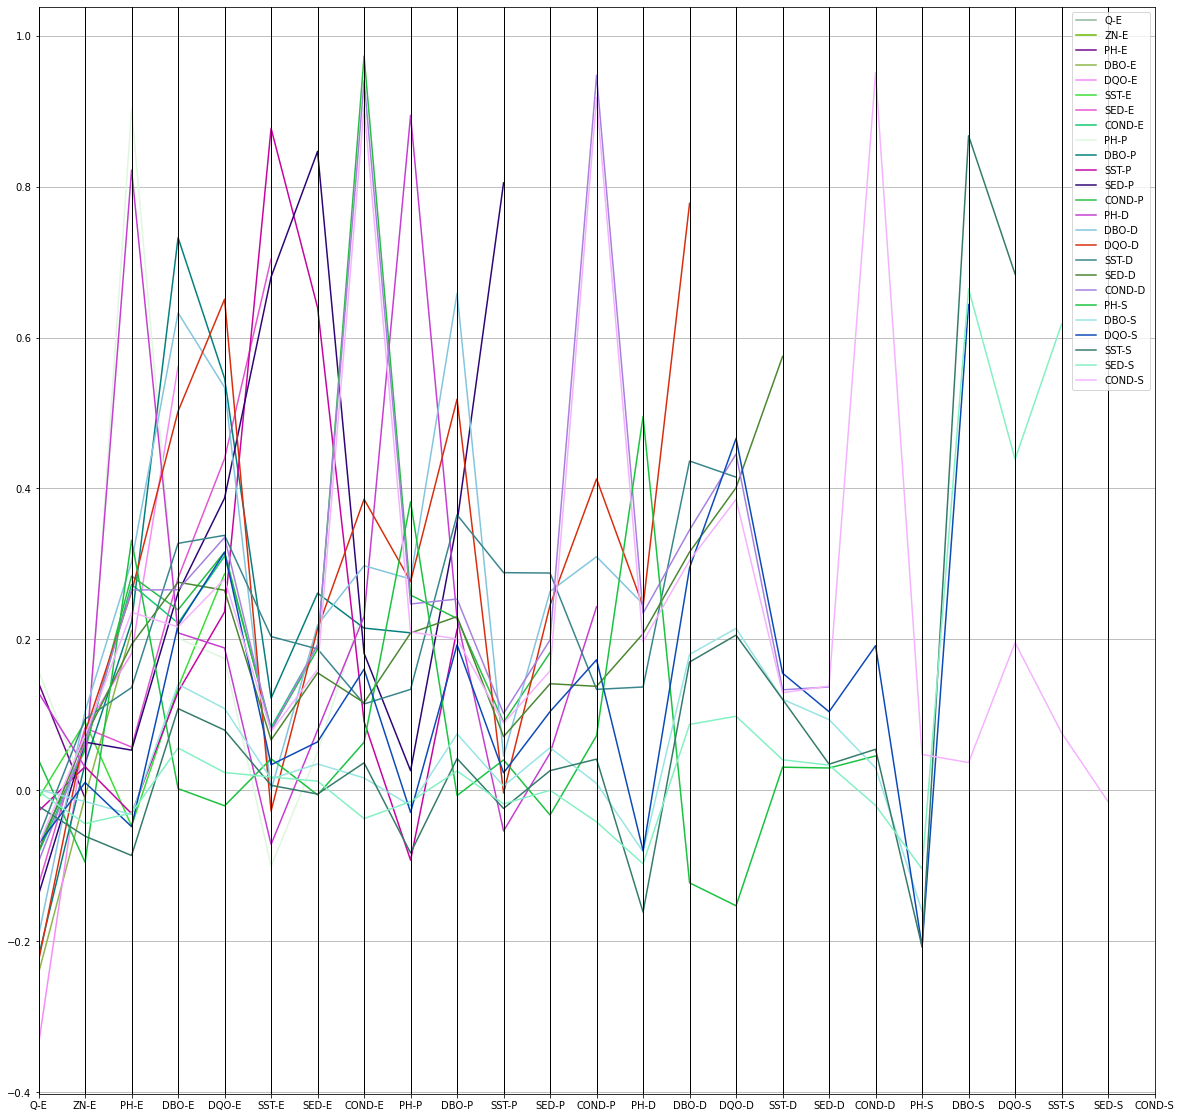

In [12]:
#Matriz de Correlação
corr_data_mean_normalize = data_mean_normalize[wtf.cols_group('variable')].corr() 
max_corr = []
min_corr = []
id_max_corr = []
for i in range(corr_data_mean_normalize.shape[0]):
    for j in range(i+1):
        corr_data_mean_normalize.iloc[j][i] = np.nan
#max_corr.append(max(cov_data_mean_normalize.iloc[i,:]))
#min_corr.append(min(cov_data_mean_normalize.iloc[i,:]))
#id_max_corr.append((cov_data_mean_normalize.iloc[i,:]).idxmax())
#cov_data_mean_normalize['max_corr'] = max_corr
#cov_data_mean_normalize['id_max_corr'] = id_max_corr
#cov_data_mean_normalize[['max_corr','id_max_corr']]
corr_data_mean_normalize['index'] = corr_data_mean_normalize.index 
plt.figure(figsize=(20,20))
pd.plotting.parallel_coordinates(corr_data_mean_normalize, class_column = 'index')


In [13]:
#Heatmap com as maiores correlações 
%matplotlib qt
#variáveis de saida 
lista = wtf.cols_group('variable')
for i in wtf.cols_group('output'):
    lista.remove(i)
corr_matrix = corr_data_mean_normalize[lista]
corr_matrix = corr_matrix.loc[lista]
for i in corr_matrix.index:
    for j in corr_matrix.columns:
        a = corr_matrix.loc[i][j]
        if abs(a) < 0.5:
            corr_matrix.loc[i][j] = np.nan
        
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='YlGnBu',annot=True)

plt.show()

    Foram representadas apenas as varáveis com o módulo de covariância superior a um número determinado a fim de focar nas principais relações, definiu corr >= 0.9
    

In [14]:
interact(wtf.var_var_graph, 
            dados=fixed(data_mean_normalize),
            classif = widgets.SelectMultiple(
            options = wtf.cols_group('levelS')+['level_G'],
            value=['level_G'],
            description='Classificação',
            disabled=False
            ),
            var1 = widgets.SelectMultiple(
            options = wtf.cols_group('value'),
            value=['Q-E'],
            description='Var eixo x',
            disabled=False
            ),
            var2 = widgets.SelectMultiple(
            options = wtf.cols_group('value'),
            value=['Q-E'],
            description='Var eixo y',
            disabled=False
            ))



interactive(children=(SelectMultiple(description='Var eixo x', index=(0,), options=('Q-E', 'ZN-E', 'PH-E', 'DB…

<function water_treatment_functions.var_var_graph(dados, var1, var2, classif)>

- Há uma área bem definida que o PH-P e PH-D varia de acordo com o PH-E, assim, no geral, pode-se dizer tem uma equação
- COND-E apresenta uma forte relação com os demais COND, sendo que com a passagens das etapas a inclinação da reta diminui
- Nos dias com 2settler problems, SED-S (saída de sedimentos) tendem a ser maiores e apresentar menor performance global
- SST e o SSF tem uma relação forte na entrada e vai diminuindo com o passar das etapas E,P,D e S.

In [15]:
#Definir qual dos COND manter
sns.heatmap(corr_data_mean_normalize.loc[wtf.cols_group('COND')][wtf.cols_group('COND')],annot=True)

<AxesSubplot:title={'center':'Q-E vs Q-E'}>

COND-P apresenta as maiores correlações com as demais variáveis, o que faz sentido pois é a etapa mais próxima de ambas. Portanto somente este será mantido nas análises 

Limpeza dos Dados: os dados originais estão salvos em df_backup caso queira utilizálos no futuro

In [16]:
#Limpeza dos dados com correlação próximas
#Colunas
    #elevada correlação ao COND-P
limp = ['COND-E','COND-D']
    #Será calculado novamente, no entanto não faz sentido a maneira como eles calcularam, 
    # considerando que o valor mínimo é nulo. Será calculado e analisado nas análises de cada operação
limp = limp + wtf.cols_group('performance_old') + wtf.cols_group('performance_new')
data = data.drop(limp,axis=1)
#Linhas
    #elevado n° de vazios
limp = ['1990-01-31', '1990-11-12', '1991-02-22']
data = data[data.index.isin(limp)==False]

In [17]:
#Estatística com classificação simplificada de dados brutos
class_data2 = data.groupby(by=['class_simp']).mean()
class_data2 = (class_data2 - class_data2.loc['Normal'])/class_data2.loc['Normal']
class_data2.style.format(('{:.2%}'))

,Q-E,ZN-E,PH-E,DBO-E,DQO-E,SST-E,SSV-E,SED-E,PH-P,DBO-P,SST-P,SSV-P,SED-P,COND-P,PH-D,DBO-D,DQO-D,SST-D,SSV-D,SED-D,PH-S,DBO-S,DQO-S,SST-S,SSV-S,SED-S,COND-S,level_PH-S,level_ZN-S,level_SED-S,level_COND-S,level_SST-S,level_DBO-S,level_DQO-S,level_G
class_simp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Normal,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Secondary settler problems,4.54%,-50.47%,-3.29%,2.07%,-4.38%,-1.04%,-3.76%,-10.73%,-1.88%,0.26%,-15.29%,-1.20%,-10.95%,-15.65%,-3.13%,4.25%,16.72%,13.79%,-5.85%,77.68%,-2.21%,602.17%,212.88%,446.65%,-0.54%,4531.78%,-6.07%,0.20%,0.00%,-69.95%,21.67%,-100.00%,-100.00%,-100.00%,-100.00%
Solids overload,-1.10%,-48.63%,-2.10%,14.04%,18.60%,402.43%,-48.92%,328.42%,-2.66%,8.02%,343.50%,-44.84%,360.22%,6.57%,-2.45%,-17.55%,-22.90%,-11.08%,-6.37%,-10.58%,-2.12%,23.29%,35.31%,41.95%,-1.01%,121.16%,5.26%,0.20%,0.00%,-29.88%,-14.83%,23.70%,11.03%,-56.03%,-100.00%
Storm,21.22%,22.61%,1.74%,-40.06%,-29.09%,214.88%,-67.30%,7.47%,0.22%,-29.77%,251.38%,-62.10%,42.13%,57.37%,0.43%,-48.17%,-46.72%,19.27%,-36.31%,-26.84%,1.77%,-48.52%,-39.82%,-40.36%,-5.25%,-77.88%,82.55%,0.20%,0.00%,5.18%,-14.83%,64.94%,48.04%,31.91%,60.69%


Secondary settler problems (terminados em D)
- redução da entrada de zinco, não parece estar relacionado com o volume pois em ambas as estátisticas estão relativas ao volume, talvez haja alguma relação que melhore essa relação
- os inputs dessa operação não foram afetados, no entanto na saída há um grande aumento em DBO-S,DQO-S, SED-S, SS-S
- queda na performance como um todo

Solids overload
- redução da entrada de zinco (ZN-E), msms considerações anteriores
- Aumento da entrada se sólidos suspensos na planta (SS-E) e de sedimentos (SED-E)ao mesmo tempo que caiu a entrada de sólidos voláreis (SSV-E), o aumento permanece no primary settler. Já o secondary settler apresenta níveis normais e a saída apresenta elevado valores de SS e SED acima da média

Storm
- Aumento considerável de volume
- Queda das entradas de demanda de oxigênio
- Aumento dos sólidos suspenso e redução dos sólidos voláteis na entrada e se mantem no 1S
- No 2S, há uma normalização nos sólidos solúveis e queda nos sedimentos 
- Na saída, baixa demanda de oxígenio e baixo níveis de solidos sóluveis e sedimentos
- condutividade alta em todo processo

Redução das variáveis sem relevancia entre as classes 
- Entre as classificações, certas variáveis estão dentro do desvio padrão e portanto, não apresentam relevancia na diferenciação das classes: PH

In [18]:
#Grafcos para relacionar as variáveis
data_test = data_mean_normalize
sns.pairplot(data_test,vars=['COND-E','COND-P','COND-D'],corner=True,kind = 'reg',
                 plot_kws={'scatter_kws': {'alpha': 0.4}})


In [19]:
sns.pairplot(data_test,vars=['PH-E','PH-P'],corner=True,kind = 'reg',
                 plot_kws={'scatter_kws': {'alpha': 0.4}})

SECONDARY SETTLER

In [20]:
lista = ['Q-E','ZN-E']+wtf.cols_group('input_2_settler')+wtf.cols_group('output')+['class_simp']+wtf.cols_group('levelS')+['level_G']
sec_set = df_backup[lista].copy()

In [21]:
perf = ['class_simp']
for c in wtf.cols_group('performance_var'):
    sec_set['P-'+c] = (sec_set[c+'-D']-sec_set[c+'-S'])/sec_set[c+'-D']
    perf.append('P-'+c)
    sec_set = sec_set[sec_set['P-'+c].isnull()==False]
for a in lista[1:-9]:
    sec_set['A-'+a] = sec_set[a]*sec_set['Q-E']
sec_set = sec_set.replace([np.inf, -np.inf], np.nan)

In [22]:
a = sec_set[sec_set['class_simp']=='Normal']
s = pd.Series(a.mean())
s = s.append(pd.Series(['Mean'],index=['class_simp']))
s = s.loc[a.columns]
s['class_simp'] = 'Normal Mean'
a = a.append(s, ignore_index = True)
plt.figure(figsize=(10,10))
b = sec_set[sec_set['class_simp']!='Normal']
b = b.append(s, ignore_index=True)
ax = pd.plotting.parallel_coordinates(b[perf], class_column = 'class_simp', color = ['g','r','b','k'])
ax.set_ylim(-1,1)

(-1.0, 1.0)

In [23]:
a = sec_set[sec_set['class_simp']=='Normal']
s = pd.Series(a.mean())
s = s.append(pd.Series(['Mean'],index=['class_simp']))

In [24]:
s

Q-E                37278.308057
ZN-E                   2.284018
PH-D                   7.827294
DBO-D                 122.87844
DQO-D                275.293578
SST-D                 93.841743
SED-D                  0.409404
COND-D              1483.731651
PH-S                   7.715596
DBO-S                 18.545872
DQO-S                 84.486239
SST-S                  21.03211
SED-S                  0.022225
COND-S              1486.582569
level_PH-S                  1.0
level_ZN-S                  1.0
level_SED-S            0.954128
level_COND-S           0.587156
level_SST-S            0.607798
level_DBO-S            0.672018
level_DQO-S            0.759174
level_G                0.305046
P-DBO                  0.842108
P-DQO                   0.68687
P-SST                  0.767579
P-SED                  0.923991
P-COND                 -0.03405
A-ZN-E             85374.902482
A-PH-D            292174.000948
A-DBO-D          4557646.594787
A-DQO-D         10155045.369668
A-SST-D 

In [25]:
plt.figure(figsize=(10,10))
ax = pd.plotting.parallel_coordinates(a[perf], class_column = 'class_simp', color = ['y','b'])
ax.set_ylim(-1,1)

(-1.0, 1.0)

- Na operação normal, as performance ficam concentradas em certos níveis menos a performance de SSV (sólidos suspensos voláteis) que apresenta uma grande variação de valores desde <-100%, ou seja, aumento da quantidade até redução de 50%. É interessante identificar o fator não analisado que pode ter influência nisso
- No 2-Settler-Problems a performance como um todo tende a ser menor que nos demais operações, com excessão de COND e SSV, sendo este apresenta alguns casos com performance menor
- Os dados de solid overload são confusos pois dos dois pontos, um apresenta performance abaixo da média enquanto o outro são dados padrão.
    

In [26]:
print(sec_set.columns)

Index(['Q-E', 'ZN-E', 'PH-D', 'DBO-D', 'DQO-D', 'SST-D', 'SED-D', 'COND-D',
       'PH-S', 'DBO-S', 'DQO-S', 'SST-S', 'SED-S', 'COND-S', 'class_simp',
       'level_PH-S', 'level_ZN-S', 'level_SED-S', 'level_COND-S',
       'level_SST-S', 'level_DBO-S', 'level_DQO-S', 'level_G', 'P-DBO',
       'P-DQO', 'P-SST', 'P-SED', 'P-COND', 'A-ZN-E', 'A-PH-D', 'A-DBO-D',
       'A-DQO-D', 'A-SST-D', 'A-SED-D', 'A-COND-D', 'A-PH-S', 'A-DBO-S',
       'A-DQO-S', 'A-SST-S', 'A-SED-S', 'A-COND-S'],
      dtype='object')


In [27]:
def mult_disp(dados, m):
    sns.pairplot(dados[[m[0]]+perf], hue='class_simp')
    print('pronto')
    return
interact(mult_disp, 
         dados=fixed(sec_set),
            m = widgets.SelectMultiple(
            options = sec_set.columns,
            value=['Q-E'],
            description='Add variable',
            disabled=False
            ))

interactive(children=(SelectMultiple(description='Add variable', index=(0,), options=('Q-E', 'ZN-E', 'PH-D', '…

<function __main__.mult_disp(dados, m)>

Comparação entre as performances
- Nenhuma relação relevante: A-ZN-E, A-PH-D, A-DBO-D, A-DQO-D, A-SSV-D, A-SED-D,
- A performance de SSV tende a ser menor nos casos de storm  
- Nenhuma das variáveis da entrada da planta, Q-E e ZN-E, afetam a performance. 
- O PH tende a ser um pouco menor nos casos de solid overload
- O DBO tende a ficar menor nos casos de storm 
- Percebe-se uma relação linear entre P-SSV e SSV, as equações podem se encontradas no gráfico abaixo


In [28]:
interact(wtf.var_var_graph, 
         dados=fixed(sec_set),
            classif = widgets.SelectMultiple(
            options = wtf.cols_group('levelS')+['level_G'],
            value=['level_G'],
            description='Classificação',
            disabled=False
            ),
            var1 = widgets.SelectMultiple(
            options = sec_set.columns,
            value=['Q-E'],
            description='Var eixo x',
            disabled=False
            ),
            var2 = widgets.SelectMultiple(
            options = sec_set.columns,
            value=['Q-E'],
            description='Var eixo y',
            disabled=False
            ))


interactive(children=(SelectMultiple(description='Var eixo x', index=(0,), options=('Q-E', 'ZN-E', 'PH-D', 'DB…

<function water_treatment_functions.var_var_graph(dados, var1, var2, classif)>

t-SNE (t-Distributed Stochastic Neighbor Embedding)
- Aumenta a distância entre pontos em 2 dimensões considerando um n° maior de dimensões 
- Identificar as variáveis mais importantes
    - Fazer uma classificação com base nos quartis de cada variável e plotar

In [29]:
tsne = data_mean_normalize.copy()
tsne = tsne.drop(columns = wtf.cols_group('performance_old')+wtf.cols_group('performance_new'))
interact(wtf.f_tsne, 
        data=fixed(tsne),
        hue = widgets.SelectMultiple(
        options = tsne.columns,
        value=['class_simp'],
        description='Classificação',
        disabled=False
        ),
        n = widgets.IntSlider(
        value=50,
        min=10,
        max=1000,
        step=1,
        description='Learning Rate',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
))

interactive(children=(IntSlider(value=50, continuous_update=False, description='Learning Rate', max=1000, min=…

<function water_treatment_functions.f_tsne(data, n=50, hue=None)>

PCA

In [30]:
data_pca = data.copy()
#Lista de variáveis a serem consideradas: as varíaveis de saída estão representadas nas classificações
lista_var = wtf.cols_group('clean_variable')
for i in wtf.cols_group('output'):
    lista_var.remove(i)
#Linhas com outliers que atrapalham o PCA
#Lista com os outliers
        #PCA 2 
l2 = ['1990-05-06', '1991-05-28'] 
    #PCA 3
l3 = ['1990-09-14','1990-06-26', '1990-10-22', '1991-05-31']
    #PCA-5
l5 = ['1990-03-10', '1991-01-29', '1991-01-31']
l = l2+l3+l5
data_pca = data_pca[data_pca.index.isin(l)==False]
data_pca = data_pca[lista_var]
data_pca = data_pca.dropna(axis=0)
valid_rows = data_pca.index

scaler = StandardScaler()
std_df = scaler.fit_transform(data_pca)
pca_tot = PCA()
tot = pca_tot.fit_transform(std_df)

In [31]:
#Quanto maior o número, maior a capacidade do componente descrever a variância 
exp_var_ratio_tot = pca_tot.explained_variance_ratio_
orig_exp_var_ratio_tot = exp_var_ratio_tot 

In [32]:
%matplotlib qt
#Determinar o número de componentes para análise
p = 70
p = p/100 #porcentagem mínima para descrever as variáveis do sistema
n = 1
for c in exp_var_ratio_tot.cumsum():
    if c >= p:
        break
    n+=1
tam = len(exp_var_ratio_tot)+1
x = np.arange(1,tam)
plt.plot(x, exp_var_ratio_tot)
plt.plot(x, np.repeat(exp_var_ratio_tot[n-1],tam-1),label='Variância = '+str(round(100*exp_var_ratio_tot[n-1],2))+'%')
plt.xlabel('Número da principal componente')
plt.ylabel('Variância Explicada')
plt.legend()
plt.show()
"""
%matplotlib qt
plt.plot(x, exp_var_ratio_tot.cumsum())
plt.plot(x,np.repeat(c,tam-1),label='Variância = '+str(round(100*c,2))+'%')
plt.xlabel('Número de principais componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.legend()
plt.show()
print('Number of principal components = ',n)
print('Last explained variance = '+str(round(100*exp_var_ratio_tot[n-1],2))+'%')
print('Accumulated explained variance = '+str(round(100*c,2))+'%')
"""

"\n%matplotlib qt\nplt.plot(x, exp_var_ratio_tot.cumsum())\nplt.plot(x,np.repeat(c,tam-1),label='Variância = '+str(round(100*c,2))+'%')\nplt.xlabel('Número de principais componentes')\nplt.ylabel('Variância Explicada Acumulada')\nplt.legend()\nplt.show()\nprint('Number of principal components = ',n)\nprint('Last explained variance = '+str(round(100*exp_var_ratio_tot[n-1],2))+'%')\nprint('Accumulated explained variance = '+str(round(100*c,2))+'%')\n"

In [33]:
components_value = pd.DataFrame(data=pca_tot.components_,index=np.arange(1,len(data_pca.columns)+1),
                                columns=data_pca.columns)

In [34]:
#Verificar os componentes de maior importância
plt.figure(figsize=(8,10))
sns.heatmap(components_value)

<AxesSubplot:>

In [35]:
#Analisar qual o melhor número de componenetes para descrever a variancia do sistema
n = 5
pca_n = PCA(n_components = n)
n_values = pca_n.fit_transform(std_df)
#criar um data frame com o n_values
    #nome das colunas
pca_name = []
for i in range(n):
    pca_name.append('PCA-'+str(i+1))
classes = (data.loc[valid_rows]).iloc[:,-9:]
df_n_values = pd.DataFrame(data=n_values, index=classes.index,columns=pca_name)
df_n_values.index.name = 'index'
#distribuição dos componentes de cada PC
n_components_value = pd.DataFrame(data=pca_n.components_,index=np.arange(1,n+1),
                                columns=data_pca.columns)
#Variância Explificada
exp_var_ratio_n = pca_n.explained_variance_ratio_

In [36]:
%matplotlib qt
#Gráfico com setas do PCA
px = 1
py = 4
n_std = 2
exp_var_x = exp_var_ratio_n[px-1]
exp_var_y = exp_var_ratio_n[py-1]
px_exp_var = str(round(exp_var_x*100,2))+'%'
py_exp_var = str(round(exp_var_y*100,2))+'%'
x = df_n_values['PCA-'+str(px)]
y = df_n_values['PCA-'+str(py)]
hue = data.loc[df_n_values.index]['level_G']
fig, ax = plt.subplots()
sns.scatterplot(x,y,hue=hue,palette=['r','b'])
ax.grid(b=True)
#definir os tamanhos máximos 
xmax = x.abs().max()*1.05
ymax = y.abs().max()*1.05
ax.set_xlim([-xmax,xmax])
ax.set_ylim([-ymax,ymax])
#nomes dos eixos
ax.set(xlabel = 'PCA-'+str(px)+' ('+px_exp_var+')', ylabel = 'PCA-'+str(py)+' ('+py_exp_var+')')
#plotar as setas

#ajustar posição das anotações
    
#Ajuste das posições dos textos para pares de PCA analisados
    #Ordem das variáveis
#['Q-E', 'ZN-E', 'PH-E', 'DBO-E', 'DQO-E', 'SST-E', 'SED-E', 'PH-P','DBO-P', 'SST-P', 'SED-P', 'COND-P', 'PH-D', 'DBO-D', 'DQO-D', 'SST-D','SED-D']
#   1       2       3       4       5        6        7        8      9        10       11        12       13      14       15       16       17 
mZN = 0
if px == 1 and py == 2:
    #PCA 1 e 2
    ajust_dx = [-0.4, 0, 0, 0, 0, -.5, 0, -0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ajust_dy = [-.4, 0.2, -0.3, 0, 0, 0, -0.2, -0.4, -0.4, 0, 0, 0, 0.1, 0.2, -0.2, 0, 0]
    a = 1.3
elif px == 3 and py == 4:
    #PCA 3 e 4
    ajust_dx = [ 0, .2, .3, -.4,  -.4,  0,  0,  -.2,  -.3, 10, 0, -.2, .1, -.5, -.5, 0, 0]
    ajust_dy = [ 0, .2, -.2, -.4,  -.4,  -.2,  -.3,  .2,  .3, .1, 0, -.3, .1, .1, .1, 0, 0]
    a = 0.9
elif px == 5 or py == 5:
    #ajuste específico para o módulo de ZN
    mZN = ymax 
else:
    #sem ajuste
    ajust_dx = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ajust_dy =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    a = 1
#fatores multiplicativos para visualizar melhor as setas
fmx = a*5*n_std*xmax/8
fmy = a*5*n_std*ymax/6.5

#n é a posição do ajuste na lista
n=0
for c in n_components_value.columns:
    dx = fmx*n_components_value[c].loc[px]
    dy = fmy*n_components_value[c].loc[py]
    #ajuste do módulo gigante de y
    if c == 'ZN-E' and mZN!=0:
        dy = mZN
    ax.arrow(0,0,dx,dy)
    ax.annotate("", xy=(dx, dy), xytext=(0, 0), arrowprops=dict(arrowstyle="->"))
    ax.text(dx+ajust_dx[n],dy+ajust_dy[n],c)
    n+=1
#Fator multiplicativo para não fugir do gráfico
m = xmax*ymax/(6*8.5)

#definir os centroídes
    #true
bool_df = df_n_values.copy()
bool_df['level_G'] = hue
bool_df = bool_df[bool_df['level_G']==True]
bool_x = bool_df['PCA-'+str(px)]
bool_y = bool_df['PCA-'+str(py)]
    #plotar elipse
wtf.confidence_ellipse(bool_x, bool_y, ax=ax, n_std=n_std, facecolor='b', alpha=.3)
    #False
bool_df = df_n_values.copy()
bool_df['level_G'] = hue
bool_df = bool_df[bool_df['level_G']==False]
bool_x = bool_df['PCA-'+str(px)]
bool_y = bool_df['PCA-'+str(py)]

wtf.confidence_ellipse(bool_x, bool_y, ax=ax, n_std=n_std, facecolor='r', alpha=.3)

fig.set_figheight(10)
fig.set_figwidth(10)

C:\Users\Bruno M Venturott\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [37]:
#Gráfico de PCA 5
fig,ax = plt.subplots()
n = 5
n_exp_var = exp_var_ratio_n[n-1]
exp_var = pd.DataFrame(df_n_values['PCA-'+str(n)])
vec = n_components_value.loc[n]
exp_var['level_G'] = data.loc[df_n_values.index]['level_G']
colours = ['b','r']
bool_list = [True,False]
for i in range(2):
    x = exp_var[exp_var['level_G']==bool_list[i]]['PCA-'+str(n)]
    y = stats.kde.gaussian_kde(x)
    y1 = y(x)
    y2 = np.repeat(0,len(y1))
    df = pd.DataFrame()
    df['x'] = x
    df['y1'] = y1
    df = df.sort_values(by='x')
    x.plot.kde(ax=ax, color=colours[i])
    ax.fill_between(df.iloc[:,0],y1=df.iloc[:,1],y2=y2,color=colours[i],alpha=0.3,interpolate=True,where=(y1>y2))
ax.legend(bool_list, title='level_G')
maior = 15
menor = -5
f = 0.5
posicoes = np.linspace(start=menor+f,stop=maior-f,num=len(vec.index))
vec = vec.sort_values(ascending=False)
ax.set_xlim([-5,15])
ax.bar(posicoes,vec,color='g',alpha=0.5)
for v in range(len(vec)):
    ax.text(posicoes[v],vec[v],vec.index[v],ha='center',fontsize=8)
ax.set_ylabel('Densidade')
ax.set_xlabel('PCA-'+str(n)+' ('+str(round(n_exp_var*100,2))+'%'+')')

Text(0.5, 0, 'PCA-5 (5.84%)')

PCA-1 vs PCA-2
- Quando comparamos os dois principais componentes, percebe-se que a maioria das variáveis estão do lado direito. Possivelmente essa direção pode ser interpretada como performance geral da planta onde quanto maior o valor, maior é a chance da planta não atingir os níveis satisfatórios. Além disso, as setas estão em direção ao centróide oq reafirma esta ideia. Já a vazão está no sentido oposto, indicando que quanto maior a vazão, menores as chances de haver algum problema no tratamento

PCA-2 vs PCA-3
- No 1° quadrante estão SED-E e SED-P com grande módulo, enquanto a SED-D encontra-se na direção oposta, no 3° quadrante com pequeno módulo. Isso indica que SED-E e SED-P apresentam influências próximas nos componetes 2 e 3, enquanto o SED-D possui pouca influência. Algo similar acontece com o SST-E e SST-P, mas o SST-D está no mesmo quadrante e com quase nenhuma influência no componente 3 e um pouco maior no 2   
- No 2° quadrante estão todas as variáveis PH e a vazão
- A elipse de confiança dos casos de performance normal estão mais distribuidas na 3 componente com o centroide com a componete 3 positiva, logo, as variáveis no 1° e 2° quadrante, quanto o maior o valor maior a chance da operação ser normal
- No 4° quadrante, estão as variáveis DBO e DQO da entreda e do primeiro decantador, e as do segundo decantador estão no 3° quadrante com maior módulo

PCA-3 vs PCA-4
- As variáveis SED-D e SST-D possuem influência positiva no PCA-4, mas a elipse de confiança se distribui na direção do PCA-3
Os demais principais componentes não apresentam uma informação significativa 

In [38]:
def pca_pp_heat(data, n, hue):
    hue = hue[0]
    #Lista de variáveis a serem consideradas: remover as variáveis de saída pois elas são as classificações
    lista = wtf.cols_group('clean_variable')
    for i in wtf.cols_group('output'):
        lista.remove(i)
    #Lista com os outliers
            #PCA 2 
    l2 = ['1990-05-06', '1991-05-28'] 
        #PCA 3
    l3 = ['1990-09-14','1990-06-26', '1990-10-22', '1991-05-31']
        #PCA-5
    l5 = ['1990-03-10', '1991-01-29', '1991-01-31','1991-08-07','1990-12-19', '1991-09-07','1990-04-22', '1990-10-07']
    
    l = l2+l3+l5
    #Criando o std_df
    data_pca = data.copy()
    data_pca = data_pca[data_pca.index.isin(l)==False]
    data_pca = data_pca[lista]
    data_pca = data_pca.dropna(axis=0)
    valid_rows = data_pca.index

    scaler = StandardScaler()
    std_df = scaler.fit_transform(data_pca)
    #Criando os dados do pca
    pca_n = PCA(n_components = n)
    n_values = pca_n.fit_transform(std_df)
    #criar um data frame com o n_values
        #nome das colunas
    pca_name = []
    for i in range(n):
        pca_name.append('PCA-'+str(i+1))
        #classes = colunas com os levels
    classes = (data.loc[valid_rows])
    df_n_values = pd.DataFrame(data=n_values, index=classes.index,columns=pca_name)
    df_n_values.index.name = 'index'
    #distribuição de componentes de cada PC 
    n_components_value = pd.DataFrame(data=pca_n.components_,index=pca_name,
                                    columns=data_pca.columns)   
    df_pca = df_n_values.merge(classes,left_on='index', right_on = 'index') 
    sns.pairplot(df_pca,vars=df_pca.columns[:n],hue=hue, corner=True,kind = 'reg',
                 plot_kws={'scatter_kws': {'alpha': 0.4}})
    plt.show()
    #Definir o zero como branco no mapa de cor
    v = n_components_value.abs().max().max()
    plt.figure(figsize=(15,8))
    sns.heatmap(n_components_value.T, cmap = sns.diverging_palette(220, 20, as_cmap=True),
                vmin=-v, vmax=v,annot=True)
    plt.show()
    print(data[hue].value_counts())
    return 

def pca_value(data, n, hue):
    hue = hue[0]
    #Lista de variáveis a serem consideradas: remover as variáveis de saída pois elas são as classificações
    
    lista = wtf.cols_group('clean_variable')
    for i in wtf.cols_group('output'):
        lista.remove(i)
    #Lista com os outliers
        #PCA 2 
    l2 = ['1990-05-06', '1991-05-28'] 
        #PCA 3
    l3 = ['1990-09-14','1990-06-26', '1990-10-22', '1991-05-31']
        #PCA-5
    l5 = ['1990-03-10', '1991-01-29', '1991-01-31','1991-08-07','1990-12-19', '1991-09-07','1990-04-22', '1990-10-07']
    l = l2+l3+l5
    #Criando o std_df
    data_pca = data.copy()
    data_pca = data_pca[data_pca.index.isin(l)==False]
    data_pca = data_pca[lista]
    data_pca = data_pca.dropna(axis=0)
    valid_rows = data_pca.index

    scaler = StandardScaler()
    std_df = scaler.fit_transform(data_pca)
    #Criando os dados do pca
    pca_n = PCA(n_components = n)
    n_values = pca_n.fit_transform(std_df)
    #criar um data frame com o n_values
        #nome das colunas
    pca_name = []
    for i in range(n):
        pca_name.append('PCA-'+str(i+1))
        #classes = colunas com os levels
    classes = (data.loc[valid_rows])
    df_n_values = pd.DataFrame(data=n_values, index=classes.index,columns=pca_name)
    df_n_values.index.name = 'index'
    #distribuição de componentes de cada PC 
    n_components_value = pd.DataFrame(data=pca_n.components_,index=pca_name,
                                    columns=data_pca.columns)   
    df_pca = df_n_values.merge(classes,left_on='index', right_on = 'index') 
    return df_pca

In [39]:
%matplotlib qt
df_pca = interact(pca_pp_heat, 
        data=fixed(data),
        hue = widgets.SelectMultiple(
        options = (data.loc[valid_rows]),
        value=['level_G'],
        description='Classificação',
        disabled=False
        ),
        n = widgets.IntSlider(
        value=5,
        min=1,
        max=8,
        step=1,
        description='N° de Principal Componets',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
))

interactive(children=(IntSlider(value=5, continuous_update=False, description='N° de Principal Componets', max…

Principal Components Analysis
- Analise sobre as variáveis que apresentam o maior coeficiente em cada um dos principais componentes e verificar a capacidade de descrever a falha do sistema global e/ou cada uma das falhas individualmente

In [76]:
#Maior coeficiente de cada um dos principais componentes
l = []
for n in range(5):
    l.append(n_components_value.abs().iloc[n].idxmax())
l

['DQO-E', 'PH-P', 'SST-E', 'SED-D', 'ZN-E']

In [41]:
stat.loc[l]

,count,mean,std,min,25%,50%,75%,max
DQO-E,521.0,406.898273,0.295806,81.0,325.0,400.0,478.0,941.0
PH-P,527.0,7.829981,0.028982,7.3,7.7,7.8,8.0,8.5
SST-E,526.0,227.444867,0.597686,98.0,170.0,196.0,242.0,2008.0
SED-D,502.0,0.416733,0.912327,0.0,0.2,0.3,0.5,3.5
ZN-E,524.0,2.359065,1.165508,0.1,0.9,1.5,3.0,33.5


In [77]:
hip = data[l+['level_G']+wtf.cols_group('levelS')].copy()
hip = hip.dropna()
#Definir as series


x_label = 'SST-E'
y_label = 'SED-D'
z_label = 'ZN-E'
s_label = 'DQO-E'
c_label = 'PH-P'
#Normalizar os dados para a escala de cor se manter a mesma
    #menos o tamanho
l1 = [x_label,y_label,z_label,c_label]
for c in l1:
    hip[c] = (hip[c].max()-hip[c])/(hip[c].max()-hip[c].min())
#Lista de marcadores
list_m = ['o','o','s','+']
['level_G']+wtf.cols_group('levelS')

['level_G',
 'level_PH-S',
 'level_ZN-S',
 'level_SED-S',
 'level_COND-S',
 'level_SST-S',
 'level_DBO-S',
 'level_DQO-S']

In [78]:
#separar os casos true e false
separar = False
level = 'level_G'
m = hip[level].unique()
#definir mínimo e máximos do gráfico
xmax = 1
ymax = xmax
zmax = ymax
xmin = 0
ymin = 0
zmin = 0
#fator multiplicativo para o tamanho dos pontos
fm = 1/5

#Plotar o gráfico
    #Permite a interação com o gráfico
%matplotlib qt 

fig = plt.figure()


if separar==False:
    ax = fig.add_subplot(1,1,1, projection='3d')
    colors = ['Greens','Reds']
for classe in range(len(m)):
    if separar:
        ax = fig.add_subplot(1,2,classe+1, projection='3d')
        colors = ['Greys','Greys']
    hip_int = hip[hip[level]==m[classe]]
    x = hip_int[x_label]
    y = hip_int[y_label]
    z = hip_int[z_label]
    #adequar o tamanho do plot
    s = fm*hip_int[s_label]+0.01
    c = hip_int[c_label]+0.01
    p = ax.scatter(x,y,z, s=s, c=c, label=m[classe],marker=list_m[classe],cmap=colors[classe])
    plt.colorbar(p,shrink=0.5, label=c_label)
    #Iniciar com a proporção entre os eixos mais adequada
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_zlim(zmin,zmax)
    ax.legend(title=level)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    

'level_G','level_COND-S'
- Única observação é no gráfico com os casos verdadeiros e juntos, a partir do ponto onde os 3 eixos são máximos olhando para o ponto (0,0,0) tem-se quem o há uma grande concentração de círculos (true) e a medida que o zoom é aplicado tem-se o aumento do n° de triangulos (false).Além disso, observa-se que as esferas a partir do ponto máximo aumentam a medida que elas se afastam do ponto de observação. Por fim, ao observar por todos os lados, percebe-se que o lado SED e ZN tem uma concentração de valores falsos enquanto nos demais lados são verdadeiros


Norm Mean


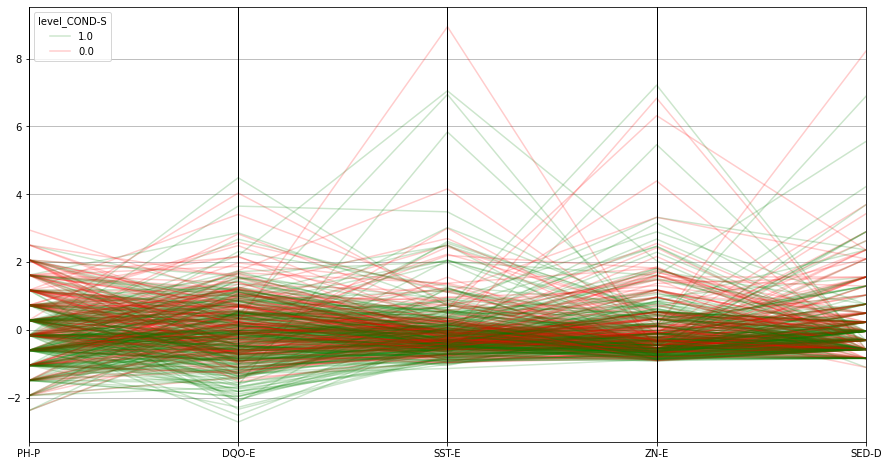

In [44]:
%matplotlib inline
#Normalizar os dados?
Norm = 2
Filter = 'level_G' 
hip = data[l+['level_G']+wtf.cols_group('levelS')].copy()
hip = hip.dropna()
if Norm==1:
    print('Norm Máx Min')
    for c in l:
        hip[c] = (hip[c].max()-hip[c])/(hip[c].max()-hip[c].min())
elif Norm==2:
    print('Norm Mean')
    for c in l:
        hip[c] = (hip[c]-hip[c].mean())/hip[c].std()
else:
    print('No Norm')
level = 'level_COND-S'
#Alterar a ordem
l = ['PH-P', 'DQO-E','SST-E', 'ZN-E','SED-D']
plt.figure(figsize = (15,8))
ax = plt.axes()
pd.plotting.parallel_coordinates(hip[l+[level]], class_column = level, color=['g','r'], 
                                 alpha=0.2, ax=ax)

ax.legend(title=level)
#hip = hip[hip[Filter]==False]
#pd.plotting.parallel_coordinates(hip[l+[Filter]], class_column = Filter, color=['b'], alpha=.3, ax=ax)
#plt.show()

Bruto
- Entre o DQO-E e o PH-P percebese que há uma divisão entre a operação normal e anormal onde a primeira se cocentra em valores menores de DQO enquanto a segunda em valores maiores. Isso indica que quanto maior o valor de DQO-E maior a dificuldade da planta em transformá-lo dentro das especificações

Não encontrei nenhuma outra relação interessante


Análise das principais variáveis do 1° PC

In [68]:
#df_n_values: valores por index
#n_components_value: compornetes do pca
l = np.array(n_components_value.iloc[0].abs().nlargest(n=5).index)
l = ['DQO-E', 'DQO-D', 'DBO-D', 'DBO-P', 'DBO-E']
"""
Logo, a partir dos 5 maiores do 1° PC, desenvolve-se a hipótese de que as variáveis DBO e DQO de todas as correntes são capazes de descrever as falhas 
do sistema
"""


'\nLogo, a partir dos 5 maiores do 1° PC, desenvolve-se a hipótese de que as variáveis DBO e DQO de todas as correntes são capazes de descrever as falhas \ndo sistema\n'

In [69]:
#Normalizar os dados?
Norm = 2
level = 'level_G' 
hip = df_backup[(['level_G']+wtf.cols_group('levelS')+wtf.cols_group('levelP')+l)].copy()
hip = hip.dropna()
if Norm==1:
    print('Norm Máx Min')
    for c in l:
        hip[c] = (hip[c].max()-hip[c])/(hip[c].max()-hip[c].min())
elif Norm==2:
    print('Norm Mean')
    for c in l:
        hip[c] = (hip[c]-hip[c].mean())/hip[c].std()
else:
    print('No Norm')
#Alterar a ordem
l = ['DQO-E', 'DQO-D', 'DBO-D', 'DBO-P', 'DBO-E']
plt.figure(figsize = (15,8))
ax = plt.axes()
pd.plotting.parallel_coordinates(hip[l+[level]], class_column = level, color=['g','r','g'], 
                                 alpha=0.2, ax=ax)

ax.legend(title=level,loc='upper right')

Norm Mean


Percebe-se uma concentração de linhas verdes na parte de baixo na normalização pela média, no entanto, pela normalização máx e min, há uma concentração de linhas na parte superior

In [70]:
hip = df_backup[(['level_G']+wtf.cols_group('levelS')+wtf.cols_group('levelP')+l)].copy()
hip = hip.dropna()
x_label = l[4]
y_label = l[3]
z_label = l[2]
s_label = l[1]
c_label = l[0]
#Normalizar os dados para a escala de cor se manter a mesma
    #menos o tamanho
l1 = [x_label,y_label,z_label,c_label]
for c in l1:
    hip[c] = (hip[c].max()-hip[c])/(hip[c].max()-hip[c].min())
#Lista de marcadores
list_m = ['o','o','s','+']
['level_G']+wtf.cols_group('levelS')

['level_G',
 'level_PH-S',
 'level_ZN-S',
 'level_SED-S',
 'level_COND-S',
 'level_SST-S',
 'level_DBO-S',
 'level_DQO-S']

In [71]:
#separar os casos true e false
separar = False
level = 'level_G'
m = hip[level].unique()
#definir mínimo e máximos do gráfico
xmax = 1
ymax = xmax
zmax = ymax
xmin = 0
ymin = 0
zmin = 0
#fator multiplicativo e exponencial para o tamanho dos pontos
fm = 1/10
fe = 0.3
#Plotar o gráfico
    #Permite a interação com o gráfico
%matplotlib qt 

fig = plt.figure()


if separar==False:
    ax = fig.add_subplot(1,1,1, projection='3d')
    colors = ['Greens','Reds']
for classe in range(len(m)):
    if separar:
        ax = fig.add_subplot(1,2,classe+1, projection='3d')
        colors = ['Greys','Greys']
    hip_int = hip[hip[level]==m[classe]]
    x = hip_int[x_label]
    y = hip_int[y_label]
    z = hip_int[z_label]
    #adequar o tamanho do plot
    s = fm*(1+r**fe)*hip_int[s_label]
    c = hip_int[c_label]+0.01
    p = ax.scatter(x,y,z, s=s, c=c, label=m[classe],marker=list_m[classe],cmap=colors[classe])
    plt.colorbar(p,shrink=0.5, label=c_label)
    #Iniciar com a proporção entre os eixos mais adequada
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_zlim(zmin,zmax)
    #ax.legend(title=level,loc=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

"""
s_base = hip[s_label].sort_values()
s_len = int(len(s_base)/4)
lines = ax.get_lines()
for r in range(4):
    ax.scatter([],[],c='k', alpha=0.3, s=fm*(1+r**fe)*s_base[s_len+s_len*r], label=int(s_base[s_len+s_len*r]))
legend1 = ax.legend(title=level+'/'+s_label,loc='upper left',bbox_to_anchor=(-0.5, 1.1))
"""
ax.legend(title='level_G')

- Quando os valores dos eixos são máximos, DQO-E é alto enquanto DQO-P é baixo.
- Os valores verdadeiros se concentram na parte central 

Análise da performance
- Verficar se há algum limite máximo de matéria que o sistema consegue tirar
    - Não exste uma quantidade máxima que pode ser removida, sendo m = varE-varS, testou m, m.Q,m/Q e 1/m mas sem sucesso em fazer o valor máximo convergir
- Verificar se o existe algum valor da entrada do segundo decantador (saída do primeiro) que causa a falha no sistema 
    - Utilizou o gráfico de comparação entre as variáveis com as classificações para determinar se existe valores máximos para falha
    - não foi identificado nenhuma variável na saída do primeiro decantador que poderia levar a falha
Não é possível calcular a performance projetada, já que não determinou-se um ponto máximo de operação, por isso, utilizou-se a distribuição por kernel gaussiano para determinar a distribuição da performance e, assim, determinar o estado da performance Low, Normal ou High  

In [49]:
data_perf = df_backup.copy()
level = wtf.cols_group('levelP')+wtf.cols_group('levelS')+['level_G']
var =  wtf.cols_group('variable')+wtf.cols_group('performance_new')
for c in var:
    data_perf[c] = (data_perf[c]-data_perf[c].mean())/data_perf[c].std()

In [50]:
#comparar falhas com as performances
%matplotlib inline
interact(wtf.var_var_graph, 
            dados=fixed(data_perf),
            classif = widgets.SelectMultiple(
            options = level,
            value=['level_G'],
            description='Classificação',
            disabled=False
            ),
            var1 = widgets.SelectMultiple(
            options = var,
            value=['Q-E'],
            description='Var eixo x',
            disabled=False
            ),
            var2 = widgets.SelectMultiple(
            options = var,
            value=['Q-E'],
            description='Var eixo y',
            disabled=False
            ))


interactive(children=(SelectMultiple(description='Var eixo x', index=(0,), options=('Q-E', 'ZN-E', 'PH-E', 'DB…

<function water_treatment_functions.var_var_graph(dados, var1, var2, classif)>

In [51]:
data_perf = df_backup.copy()
level = wtf.cols_group('levelP')+wtf.cols_group('levelS')
for c in wtf.cols_group('variable')+wtf.cols_group('performance_new'):
    data_perf[c] = (data_perf[c]-data_perf[c].mean())/data_perf[c].std()

PCA com as Performances

In [52]:
#Somente as variáveis de Performance
data_pca = data_perf[wtf.cols_group('performance_new')].dropna()
scaler = StandardScaler()
std_df = scaler.fit_transform(data_pca)
pca_tot = PCA()
tot = pca_tot.fit_transform(std_df)
perf_exp_var_ratio_tot = pca_tot.explained_variance_ratio_
perf_components_value = pd.DataFrame(data=pca_tot.components_,index=np.arange(1,len(data_pca.columns)+1),
                                columns=data_pca.columns)

#Todas as variáveis
lista_var = wtf.cols_group('clean_variable')+wtf.cols_group('performance_new')
for i in wtf.cols_group('output'):
    lista_var.remove(i)
data_pca = data_perf[lista_var].dropna()
scaler = StandardScaler()
std_df = scaler.fit_transform(data_pca)
pca_tot = PCA()
tot = pca_tot.fit_transform(std_df)
tot_exp_var_ratio_tot = pca_tot.explained_variance_ratio_

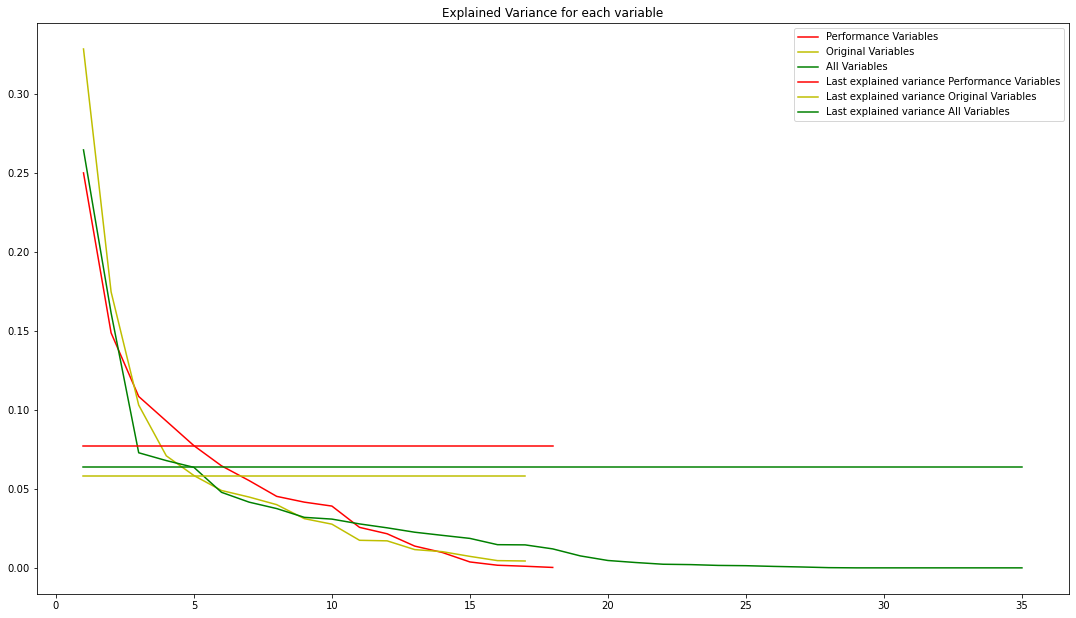

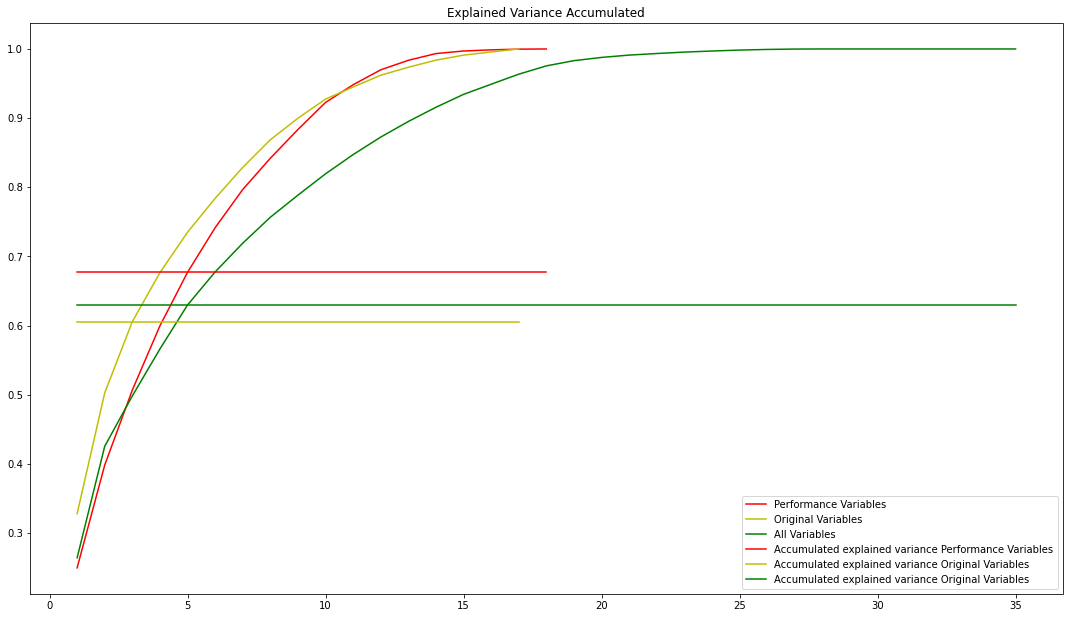

Number of principal components: Orig =  3 Perf =  5 All =  5
Last explained variance: Orig = 5.84% Perf = 7.73% All = 6.36%
Accumulated explained variance: Orig = 60.58% Perf = 67.71% All = 62.99%
Goal >=  60.0%


In [53]:
#Comparação da variância do PCA entre grupos de variáveis do sistema

#Determinar o número de componentes para análise
p = 60
p = p/100 #porcentagem mínima para descrever as variáveis do sistema
n = 1
n_orig = 1
n_tot = 1
for c in perf_exp_var_ratio_tot.cumsum():
    if c >= p:
        break
    n+=1
for c1 in orig_exp_var_ratio_tot.cumsum():
    if c1 >= p:
        break
    n_orig+=1
for c2 in tot_exp_var_ratio_tot.cumsum():
    if c2 >= p:
        break
    n_tot+=1
tam = len(perf_exp_var_ratio_tot)+1
orig_tam = len(orig_exp_var_ratio_tot)+1
tot_tam = len(tot_exp_var_ratio_tot)+1
x = np.arange(1,tam)
xo = np.arange(1,orig_tam)
xtot = np.arange(1,tot_tam)
plt.plot(x, perf_exp_var_ratio_tot,label='Performance Variables',color='r')
plt.plot(xo,orig_exp_var_ratio_tot,label='Original Variables',color='y')
plt.plot(xtot,tot_exp_var_ratio_tot,label='All Variables',color='g')
plt.plot(x, np.repeat(perf_exp_var_ratio_tot[n-1],tam-1), label='Last explained variance Performance Variables',color='r')
plt.plot(xo, np.repeat(orig_exp_var_ratio_tot[n-1],orig_tam-1),label = 'Last explained variance Original Variables',color='y')
plt.plot(xtot, np.repeat(tot_exp_var_ratio_tot[n-1],tot_tam-1),label = 'Last explained variance All Variables',color='g')
plt.title('Explained Variance for each variable')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
plt.plot(x, perf_exp_var_ratio_tot.cumsum(),label='Performance Variables',color='r')
plt.plot(xo, orig_exp_var_ratio_tot.cumsum(),label='Original Variables',color='y')
plt.plot(xtot, tot_exp_var_ratio_tot.cumsum(),label='All Variables',color='g')
plt.plot(x,np.repeat(c,tam-1),label='Accumulated explained variance Performance Variables',color='r')
plt.plot(xo,np.repeat(c1,orig_tam-1), label='Accumulated explained variance Original Variables',color='y')
plt.plot(xtot,np.repeat(c2,tot_tam-1), label='Accumulated explained variance Original Variables',color='g')
plt.title('Explained Variance Accumulated')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
print('Number of principal components: Orig = ',n_orig,'Perf = ',n,'All = ',n_tot)
print('Last explained variance: Orig = '+str(round(100*orig_exp_var_ratio_tot[n-1],2))+'%',
      'Perf = '+str(round(100*perf_exp_var_ratio_tot[n-1],2))+'%',
      'All = '+str(round(100*tot_exp_var_ratio_tot[n-1],2))+'%')
print('Accumulated explained variance: Orig = '+str(round(100*c1,2))+'%',
      'Perf = '+str(round(100*c,2))+'%',
      'All = '+str(round(100*c2,2))+'%')
print('Goal >= ',str(100*p)+'%')

Percebe-se que as variáveis originais são melhores para explicar a variância pois atingem uma porcentagem acumulada superior com o mesmo número de variáveis. Além disso, a partir de 11 variáveis, as variáveis de performance possuem maior variância acumulada.  

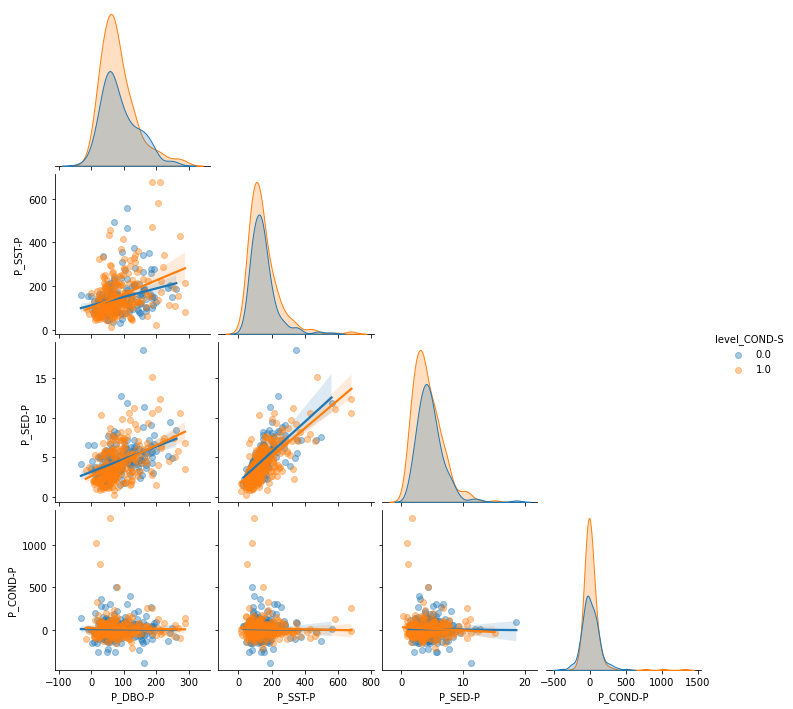

In [54]:
#pairplot com as variáveis de performance global
hue = 'level_COND-S'
stream = 'P'
#################
df_global_perf = df_backup.copy()
#Filtros
df_global_perf = df_global_perf[df_global_perf['P_SED-G']<15]
df_global_perf = df_global_perf[df_global_perf['P_COND-G']>-500]
df_global_perf = df_global_perf[df_global_perf['P_SST-G']<600]
perf_group = 'performance_'+stream+'_new'
l_perf_global = wtf.cols_group(perf_group)+wtf.cols_group('levelS')+wtf.cols_group('levelP')+['level_G']
df_global_perf = df_global_perf[l_perf_global]


sns.pairplot(df_global_perf,vars=wtf.cols_group(perf_group),hue=hue, corner=True,kind = 'reg',
                 plot_kws={'scatter_kws': {'alpha': 0.4}})

level_G,E
- Forte relação linear entre P_SED-E com P_SST-E e P_DBO-E

<AxesSubplot:>

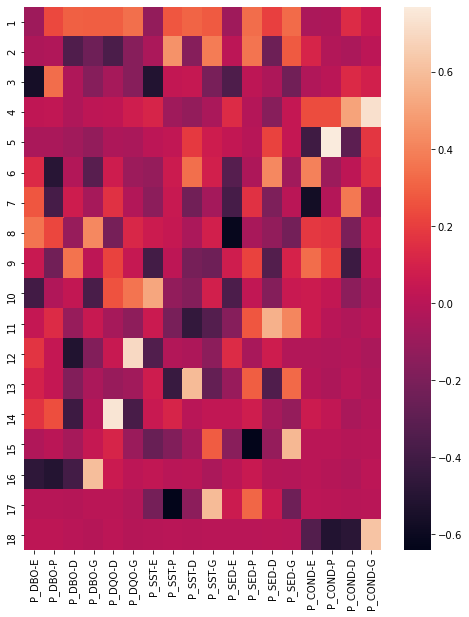

In [55]:
plt.figure(figsize=(8,10))
sns.heatmap(perf_components_value)

In [56]:
#TreeMap dsa principais performances do 1° PC
l = perf_components_value.iloc[0].abs().nlargest(n=5).index.tolist()
print(l)

['P_DQO-G', 'P_SED-P', 'P_SED-G', 'P_SST-D', 'P_DBO-D']


In [57]:
#Usar a bazuca 3D
hip = df_backup[['level_G']+wtf.cols_group('levelS')+wtf.cols_group('levelP')+l].copy()
hip = hip.dropna()
x_label = l[3]
y_label = l[2]
z_label = l[1]
s_label = l[0]
c_label = l[4]
#Tirar Outlier
hip = hip[hip[c_label]>0]
#Normalizar os dados para a escala de cor se manter a mesma
    #menos o tamanho
l1 = [x_label,y_label,z_label,c_label]
for c in l1:
    hip[c] = (hip[c].max()-hip[c])/(hip[c].max()-hip[c].min())
#Lista de marcadores
list_m = ['o','o','s','+']
['level_G']+wtf.cols_group('levelS')

['level_G',
 'level_PH-S',
 'level_ZN-S',
 'level_SED-S',
 'level_COND-S',
 'level_SST-S',
 'level_DBO-S',
 'level_DQO-S']

In [58]:

#separar os casos true e false
separar = False
level = 'level_SST-S'
m = hip[level].unique()
#definir mínimo e máximos do gráfico
xmax = 1
ymax = xmax
zmax = ymax
xmin = 0
ymin = 0
zmin = 0
#fator multiplicativo e exponencial para o tamanho dos pontos
fm = 1/10
fe = 0.3
#Plotar o gráfico
    #Permite a interação com o gráfico
%matplotlib qt 

fig = plt.figure()


if separar==False:
    ax = fig.add_subplot(1,1,1, projection='3d')
    colors = ['Greens','Reds']
for classe in range(len(m)):
    if separar:
        ax = fig.add_subplot(1,2,classe+1, projection='3d')
        colors = ['Greys','Greys']
    hip_int = hip[hip[level]==m[classe]]
    x = hip_int[x_label]
    y = hip_int[y_label]
    z = hip_int[z_label]
    #adequar o tamanho do plot
    s = fm*(1+r**fe)*hip_int[s_label]
    c = hip_int[c_label]+0.01
    p = ax.scatter(x,y,z, s=s, c=c, label=m[classe],marker=list_m[classe],cmap=colors[classe])
    plt.colorbar(p,shrink=0.5, label=c_label)
    #Iniciar com a proporção entre os eixos mais adequada
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_zlim(zmin,zmax)
    #ax.legend(title=level,loc=1)
    #ax.set_title('Estado da Operação pelas Performances Mais significantes no 1° PC')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)


s_base = hip[s_label].sort_values()
s_len = int(len(s_base)/4)
"""
lines = ax.get_lines()
for r in range(4):
    ax.scatter([],[],c='k', alpha=0.3, s=fm*(1+r**fe)*s_base[s_len+s_len*r], label=int(s_base[s_len+s_len*r]))
legend1 = ax.legend(title=level+'/'+s_label,loc='upper left',bbox_to_anchor=(0, 1.1))
"""

"\nlines = ax.get_lines()\nfor r in range(4):\n    ax.scatter([],[],c='k', alpha=0.3, s=fm*(1+r**fe)*s_base[s_len+s_len*r], label=int(s_base[s_len+s_len*r]))\nlegend1 = ax.legend(title=level+'/'+s_label,loc='upper left',bbox_to_anchor=(0, 1.1))\n"

In [59]:
matrix_treemap = []
p = 'P_DBO-G'
for p in l:
    mt_data = df_backup[['month','level_G','level_'+p]].copy()
    mt_data = mt_data.groupby(['level_G','level_'+p]).count()
    submatrix = [np.repeat('level_'+p,mt_data.shape[0]).tolist()]
    submatrix.append(mt_data.index.get_level_values(0).tolist())
    submatrix.append(mt_data.index.get_level_values(1).tolist())
    values = mt_data.iloc[:,0]
    values = round(100*values/values.sum(),2)
    submatrix.append(values.tolist())
    matrix_treemap.extend(np.array(submatrix).T)

matrix_treemap = pd.DataFrame(data=matrix_treemap, columns=['Perf','level_G','level_P','porcentage/level'])
matrix_treemap = matrix_treemap.set_index(np.arange(len(matrix_treemap)))
var = 'Q-E'
level = 'level_G'
lista = []
for i in matrix_treemap.index:
    #Pegar no nome da coluna
    name = str(matrix_treemap.loc[i]['Perf'])
    #Pegar valor do level da operação
    level_bool = matrix_treemap.loc[i][level]
    if level_bool == 'True':
        level_bool = True
    else:
        level_bool = False
    #Pegar o level da performance
    level_p = str(matrix_treemap.loc[i]['level_P'])
    #valores originais
    mean = df_backup[[name,level,var]].copy()
    #filtro do estado da operação
    mean = mean[mean[level]==level_bool]
    #filtro do nível da performance
    mean = mean[mean[name]==level_p]
    #cálculo da média
    lista.append(round(mean[var].mean(),0))
matrix_treemap[var+'.mean'] = lista
matrix_treemp = matrix_treemap[['Perf', 'level_P', 'level_G',var+'.mean','porcentage/level']]

In [60]:
a = []
for i in np.arange(30):
    a.append(str(i))
fig = pxf.treemap(matrix_treemap, path=['Perf', 'level_P', 'level_G'], values='porcentage/level',color=var+'.mean',
                 color_continuous_scale='YlOrRd',range_color=[34000,40000],hover_name=var+'.mean')
plotly.offline.plot(fig)

'temp-plot.html'

- A fase normal é a maior em todos os níveis com excessão do level_P_DBO-D
- Para P-DQO_G, P-SED-P, P-DBO-D, P-SED-G a medida que a performance aumenta, a porcentagem de casos falsos aumenta
- level_G = True  tem vazão média maior em relação ao caso Falso em cada nível de performance.
- Para cada performance, a medida que o level diminui, a vazão média aumenta. com excessão da performance de level P SST - D
- Logo, quanto menor a vazão, maior a performance, que tende a ter um percentual maior de falhas  


Coordenadas Paralelas em 3D

In [61]:
df_max_min_norm = df_backup.copy()
for c in wtf.cols_group('value')+wtf.cols_group('performance_new'):
    df_max_min_norm[c] = (df_max_min_norm[c]-df_max_min_norm[c].min())/(df_max_min_norm[c].max()-df_max_min_norm[c].min()) 

In [62]:
%matplotlib qt 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection='3d')
#Definir o tamanho das letras
size = 4
#lista de variáveis que ficaram no eixo y e z, sendo que len(y)=len(z)
n=9
colunas = wtf.cols_group('performance_new')
y_col = colunas[0:n]
z_col = colunas[n:n+n+1]
#n° de eixos = igualmente espaçados no eixo x
x = np.linspace(0, n, n)
index = df_max_min_norm[y_col+z_col].dropna().index
df_max_min_norm = df_max_min_norm.loc[index] 
#Classificação
level = 'level_G'
colors = ['g','r','y']
#definir qual classificação é: true or false ou de performance
bool_level = True
for i in df_max_min_norm.index:
    #Definir a cor
    cor_var = df_max_min_norm.loc[i][level]
    if cor_var == True or cor_var=='High':
        c = colors[0]
    elif cor_var == False or cor_var == 'Low':
        c = colors[1]
    elif cor_var == 'Normal':
        c = colors[2]
        bool_level = False
    else:
        c = 'k'     
    y = df_max_min_norm.loc[i][y_col]
    z = df_max_min_norm.loc[i][z_col]
    ax.plot(xs=x,ys=y,zs=z, color=c, alpha=0.1)
#Definir labels
if bool_level:
    labels = [True, False]
else:
    labels = ['High','Low','Normal']
n_colors = 0
for label in labels:
    ax.plot(xs=[],ys=[],zs=[], color=colors[n_colors], label=label)
    n_colors+=1
#Definir Títulos dos eixos padrão
ax.set_xlabel('y variables', fontsize=size)
ax.set_ylabel('y values', fontsize=size)
ax.set_zlabel('z values', fontsize=size)
#Definir tamanhos máximos
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_zlim((0,1))
#Definir as variáveis do eixo y
ax.set_xticks(x)
ax.set_xticklabels(y_col)
#Definir segundo eixo para as variáveis de z

for v in range(n):
    ax.text3D(x[v],y=1.1,z=1.1,s=z_col[v],horizontalalignment='center',fontsize=size)
#Título do eixo
ax.text3D(x=0.5,y=1.2,z=1.2,s='z variables',horizontalalignment='center',fontsize=size)
ax.legend(loc='center',bbox_to_anchor=(1., 1, 1., 0.),title=level)
ax.tick_params(axis='both', which='major', labelsize=size)
ax.tick_params(axis='both', which='minor', labelsize=size)

In [63]:
%%javascript
getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [64]:
#Plotar todas as variáveis
all_plot = df_backup.copy()
var = wtf.cols_group('clean_variable')+wtf.cols_group('performance_new')
for i in var:
    all_plot[i] = (all_plot[i]-all_plot[i].mean())/all_plot[i].std() 
ax = pd.plotting.parallel_coordinates(all_plot[var+['level_G']], 
                                 class_column = 'level_G', color=['g','r'], alpha=0.3)

ax.tick_params(axis='both', which='major', labelsize=8)
plt.xticks(rotation=90) 
plt.rcParams["axes.grid"] = False
plt.legend(title='level_G')
a=1

In [65]:
data = pd.read_csv(r"C:\Users\Bruno M Venturott\Documents\Poli\EAD\TCC\Python arquives\water-treatment.data",
                   sep=",", header = None, index_col=0)

In [66]:
data.shape

(527, 38)